## **Logistic Regression from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats

This function creates synthetic data with various noise patterns and with non linearly separable classes. Also, there's significant overlap between classes

In [5]:
def generate_data(n_samples=1000, n_features=2, n_clusters=3, noise_level=0.8, overlap_factor=0.5):
    """
    Generate challenging synthetic binary classification data with multiple clusters and overlap.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features for each sample
    n_clusters : int
        Number of clusters per class
    noise_level : float
        Level of noise in the data (higher = more noise)
    overlap_factor : float
        Degree of overlap between classes (higher = more overlap)
    
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        The generated feature matrix
    y : ndarray of shape (n_samples,)
        The generated target labels
    """
    n_samples = (n_samples // 2) * 2
    n_samples_per_class = n_samples // 2
    n_samples_per_cluster = n_samples_per_class // n_clusters
    
    X_list = []
    y_list = []
    
    def generate_positive_semidefinite_matrix(n):
        """Generate a random positive semidefinite covariance matrix"""
        A = np.random.uniform(-0.5, 0.5, (n, n))
        return np.dot(A, A.T) + np.eye(n)
    
    for i in range(n_clusters):
        cluster_center = np.random.uniform(-5, 5, n_features)
        
        covariance = generate_positive_semidefinite_matrix(n_features)
        covariance *= np.random.uniform(0.5, 2.0)
        
        cluster_samples = np.random.multivariate_normal(
            cluster_center,
            covariance,
            n_samples_per_cluster
        )
        
        X_list.append(cluster_samples)
        y_list.append(np.zeros(n_samples_per_cluster))
    
    for i in range(n_clusters):
        base_center = np.random.uniform(-5, 5, n_features)
        cluster_center = base_center + np.random.normal(0, overlap_factor, n_features)
        
        covariance = generate_positive_semidefinite_matrix(n_features)
        covariance *= np.random.uniform(0.5, 2.0)
        
        cluster_samples = np.random.multivariate_normal(
            cluster_center,
            covariance,
            n_samples_per_cluster
        )
        
        X_list.append(cluster_samples)
        y_list.append(np.ones(n_samples_per_cluster))
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    X += np.random.normal(0, noise_level, X.shape)
    
    n_outliers = int(0.05 * len(X))  
    outlier_idx = np.random.choice(len(X), n_outliers, replace=False)
    X[outlier_idx] += np.random.normal(0, noise_level * 3, (n_outliers, n_features))
    
    shuffle_idx = np.random.permutation(len(X))
    return X[shuffle_idx], y[shuffle_idx]

Now finally, this is is the *logistic regression* implementation. 

### Structure

##### Initialization

- Sets learning rate (how fast to learn)
- Number of training iterations
- Initializes weights and bias to None
- Creates empty list to track costs (errors)

##### Training

- Starts with weights = 0 and bias = 0
- For each iteration:
  *Calculates probability using sigmoid: p = 1/(1 + e^(-weights * X - bias))
  *Calculates error using log loss (better for probabilities)
  *Updates weights and bias to reduce errors
  *Saves the error (cost) history

##### Classification

- Takes new X values
- Returns probabilities between 0 and 1 using sigmoid
- returns 1 if probability ≥ 0.5, else 0

Think of it like finding the best S-shaped curve (sigmoid) that separates your data into two groups (classes). The model gradually adjusts the curve's position (weights) and shift (bias) to better split the data points into their respective classes. Unlike linear regression that predicts continuous values, logistic regression predicts probabilities of belonging to class 1 vs class 0.

In [8]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.costs = []
    
    def sigmoid(self, z):
        """Compute sigmoid function"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))  
    
    def initialize_parameters(self, n_features):
        """Initialize weights and bias"""
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    def fit(self, X, y):
        """Train the logistic regression model"""
        n_samples, n_features = X.shape
        self.initialize_parameters(n_features)
        
        for i in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)
            
            cost = -np.mean(y * np.log(predictions + 1e-15) + 
                          (1 - y) * np.log(1 - predictions + 1e-15))
            self.costs.append(cost)
            
            dz = predictions - y
            dw = (1/n_samples) * np.dot(X.T, dz)
            db = (1/n_samples) * np.sum(dz)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        """Predict probability of class 1"""
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)
    
    def predict(self, X):
        """Make predictions"""
        return (self.predict_proba(X) >= 0.5).astype(int)

This function uses some common metrics from scipy so we can evaluate the linear regression.

In [11]:
def calculate_statistics(y_true, y_pred, y_proba):
    """Calculate various statistical metrics"""
    accuracy = np.mean(y_true == y_pred)
    
    n = len(y_true)
    std_err = np.sqrt((accuracy * (1 - accuracy)) / n)
    ci_95 = stats.norm.interval(0.95, loc=accuracy, scale=std_err)
    
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    thresholds = np.linspace(0, 1, 100)
    fpr = []
    tpr = []
    
    for threshold in thresholds:
        pred = (y_proba >= threshold).astype(int)
        fp = np.sum((pred == 1) & (y_true == 0))
        tp = np.sum((pred == 1) & (y_true == 1))
        fn = np.sum((pred == 0) & (y_true == 1))
        tn = np.sum((pred == 0) & (y_true == 0))
        
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    
    auc = np.trapz(y=tpr, x=fpr)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'ci_95': ci_95,
        'fpr': np.array(fpr),
        'tpr': np.array(tpr)
    }

Training and testing the model.

In [14]:
X, y = generate_data(n_samples=1000, n_clusters=3, noise_level=0.8, overlap_factor=1.0)

indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]

model = LogisticRegression(learning_rate=0.1, num_iterations=1000)
model.fit(X_train, y_train)

train_proba = model.predict_proba(X_train)
test_proba = model.predict_proba(X_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_stats = calculate_statistics(y_train, train_pred, train_proba)
test_stats = calculate_statistics(y_test, test_pred, test_proba)

#### Visualize classification results

Plot the raw data, decision boundary, training progress and display key metrics.

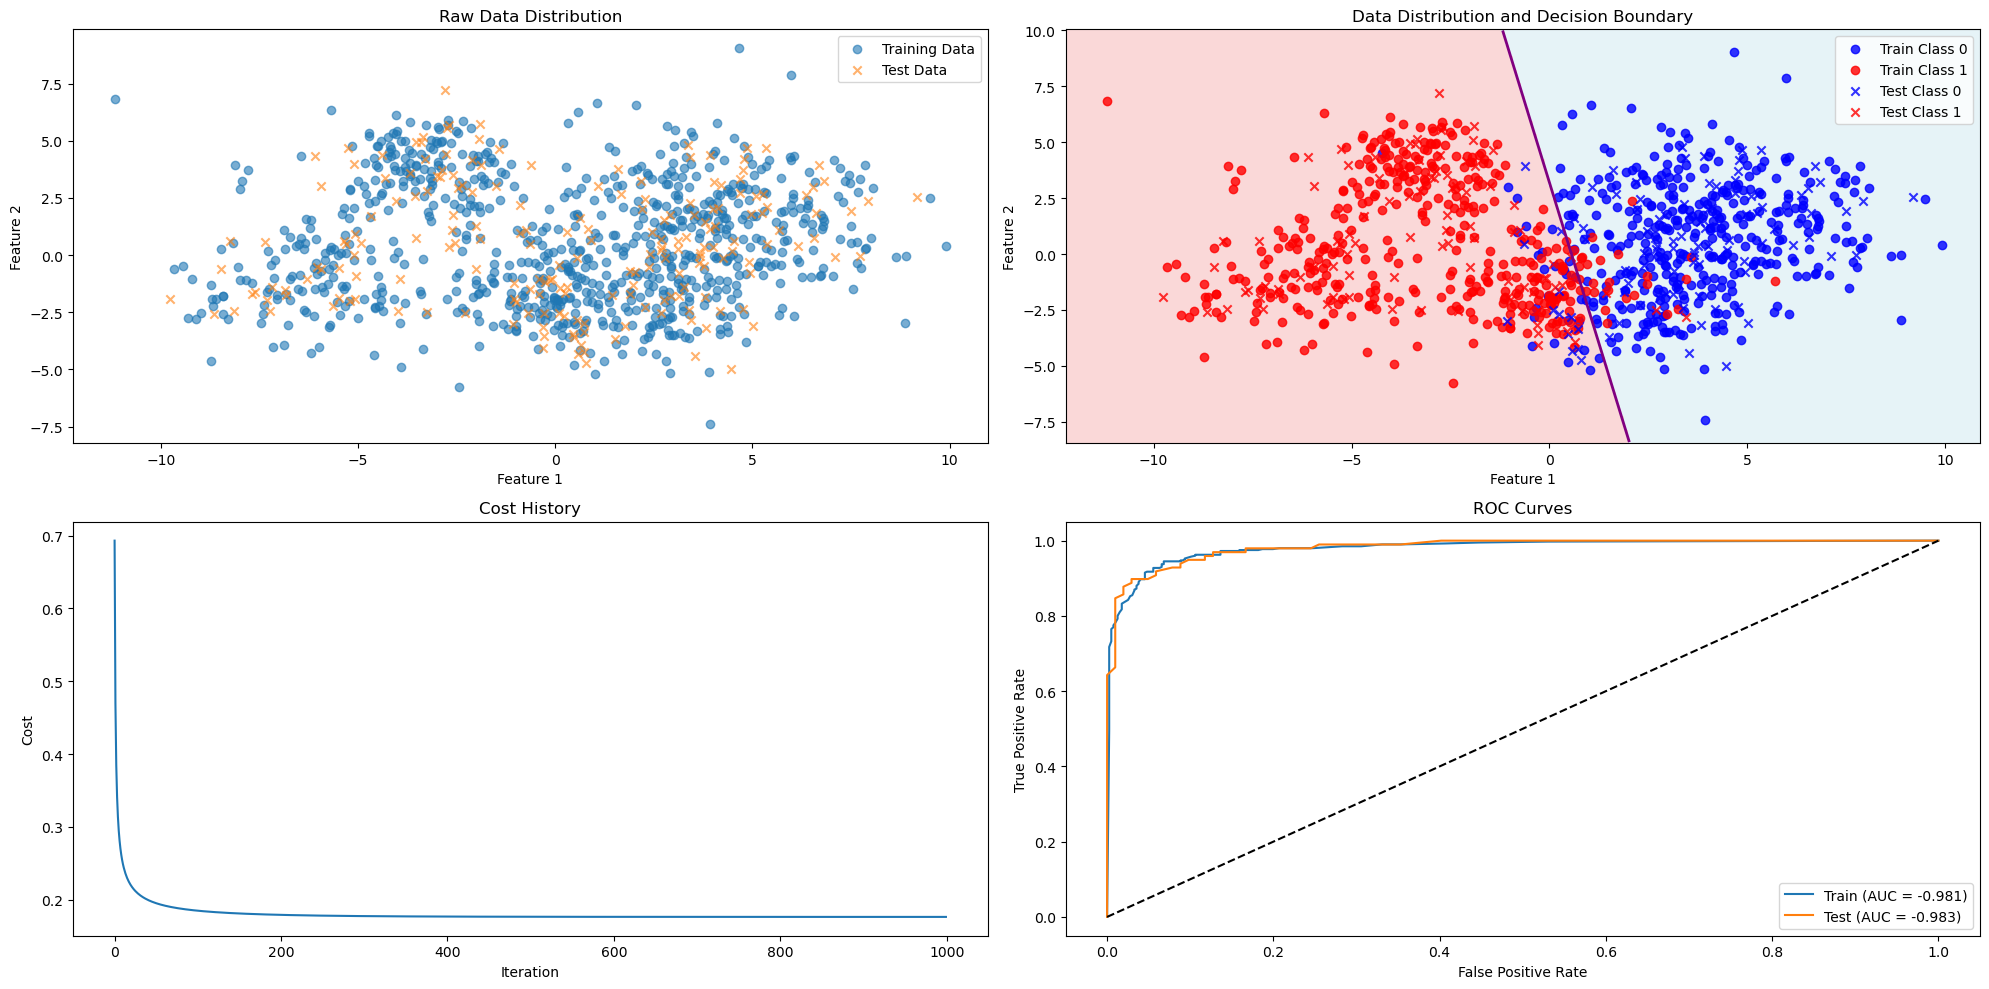


Model Statistics:
Training:
Accuracy: 0.9347
Precision: 0.9350
Recall: 0.9350
F1 Score: 0.9350
95% CI: (0.9175, 0.9576)
AUC-ROC: -0.9806

Testing:
Accuracy: 0.9200
Precision: 0.8796
Recall: 0.9694
F1 Score: 0.9223
95% CI: (0.8824, 0.9576)
AUC-ROC: -0.9827


In [17]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.6, label='Training Data')
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.6, label='Test Data', marker='x')
plt.title("Raw Data Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(2, 2, 2)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

custom_cmap = ListedColormap(['lightblue', 'lightcoral'])
plt.pcolormesh(xx, yy, Z, cmap=custom_cmap, alpha=0.3)

Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_proba = Z_proba.reshape(xx.shape)
plt.contour(xx, yy, Z_proba, [0.5], colors='purple', linewidths=2, linestyles='solid')

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
           color='blue', alpha=0.8, label='Train Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
           color='red', alpha=0.8, label='Train Class 1')

plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], 
           color='blue', alpha=0.8, marker='x', label='Test Class 0')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], 
           color='red', alpha=0.8, marker='x', label='Test Class 1')

plt.title("Data Distribution and Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(model.costs)
plt.title("Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(2, 2, 4)
plt.plot(train_stats['fpr'], train_stats['tpr'], 
         label=f"Train (AUC = {train_stats['auc']:.3f})")
plt.plot(test_stats['fpr'], test_stats['tpr'], 
         label=f"Test (AUC = {test_stats['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.show()

print("\nModel Statistics:")
print("Training:")
print(f"Accuracy: {train_stats['accuracy']:.4f}")
print(f"Precision: {train_stats['precision']:.4f}")
print(f"Recall: {train_stats['recall']:.4f}")
print(f"F1 Score: {train_stats['f1']:.4f}")
print(f"95% CI: ({train_stats['ci_95'][0]:.4f}, {test_stats['ci_95'][1]:.4f})")
print(f"AUC-ROC: {train_stats['auc']:.4f}")

print("\nTesting:")
print(f"Accuracy: {test_stats['accuracy']:.4f}")
print(f"Precision: {test_stats['precision']:.4f}")
print(f"Recall: {test_stats['recall']:.4f}")
print(f"F1 Score: {test_stats['f1']:.4f}")
print(f"95% CI: ({test_stats['ci_95'][0]:.4f}, {test_stats['ci_95'][1]:.4f})")
print(f"AUC-ROC: {test_stats['auc']:.4f}")

Now we load and test the model on a benchmark dataset(Breast Cancer), providing comparative performance metrics.

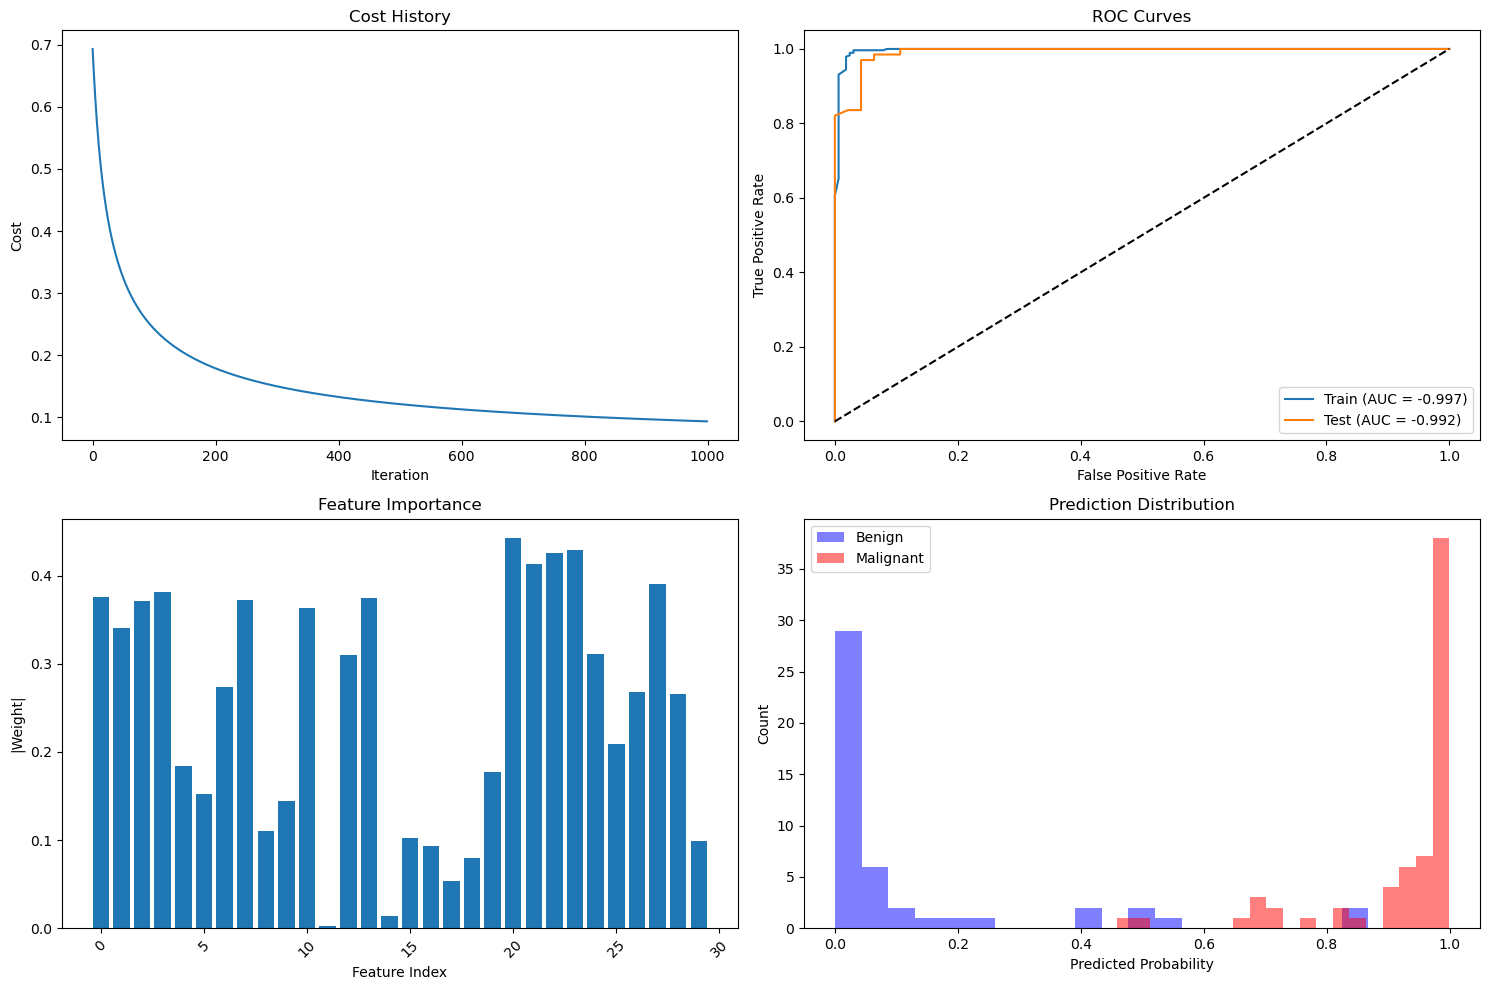


Model Performance:

Training:
Accuracy: 0.9846
Precision: 0.9829
Recall: 0.9931
F1 Score: 0.9880
95% CI: (0.9733, 0.9959)
AUC-ROC: -0.9966

Testing:
Accuracy: 0.9649
Precision: 0.9565
Recall: 0.9851
F1 Score: 0.9706
95% CI: (0.9311, 0.9987)
AUC-ROC: -0.9916

Dataset Information:
Number of samples: 569
Number of features: 30
Classes: [0 1]
Class distribution: [212 357]


In [20]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

data = load_breast_cancer()
X, y = data.data, data.target

np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
model.fit(X_train_scaled, y_train)

train_proba = model.predict_proba(X_train_scaled)
test_proba = model.predict_proba(X_test_scaled)
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

train_stats = calculate_statistics(y_train, train_pred, train_proba)
test_stats = calculate_statistics(y_test, test_pred, test_proba)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(model.costs)
plt.title('Cost History')
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.subplot(2, 2, 2)
plt.plot(train_stats['fpr'], train_stats['tpr'], 
         label=f"Train (AUC = {train_stats['auc']:.3f})")
plt.plot(test_stats['fpr'], test_stats['tpr'], 
         label=f"Test (AUC = {test_stats['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.subplot(2, 2, 3)
feature_importance = np.abs(model.weights)
plt.bar(np.arange(len(feature_importance)), feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('|Weight|')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.hist(test_proba[y_test == 0], bins=20, alpha=0.5, label='Benign', color='blue')
plt.hist(test_proba[y_test == 1], bins=20, alpha=0.5, label='Malignant', color='red')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

print("\nModel Performance:")
print("\nTraining:")
print(f"Accuracy: {train_stats['accuracy']:.4f}")
print(f"Precision: {train_stats['precision']:.4f}")
print(f"Recall: {train_stats['recall']:.4f}")
print(f"F1 Score: {train_stats['f1']:.4f}")
print(f"95% CI: ({train_stats['ci_95'][0]:.4f}, {train_stats['ci_95'][1]:.4f})")
print(f"AUC-ROC: {train_stats['auc']:.4f}")

print("\nTesting:")
print(f"Accuracy: {test_stats['accuracy']:.4f}")
print(f"Precision: {test_stats['precision']:.4f}")
print(f"Recall: {test_stats['recall']:.4f}")
print(f"F1 Score: {test_stats['f1']:.4f}")
print(f"95% CI: ({test_stats['ci_95'][0]:.4f}, {test_stats['ci_95'][1]:.4f})")
print(f"AUC-ROC: {test_stats['auc']:.4f}")

print("\nDataset Information:")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")